**QUESTION 2**

ugly ipynb coding

---
---
---

In [1]:
import pickle
import numpy as np
from pathlib import Path

from src.input import Input_uc, Input_ed_prev
from src.output import Output_uc, Output_ed_prev, Output_uc_snapshot
from src.unit_commitment import solve_uc, solve_uc_snapshot
from src.economic_dispatch import solve_ed_prev

In [2]:
num_units=122
num_periods=24
num_buses=197

In [3]:
path_folder_processed_kpg193 = Path.cwd().resolve() / "data" / "input" / "processed" / "KPG193_ver1_2"
timestamp_2022 = np.load(Path.cwd().resolve() / "data" / "input" / "processed" / "timestamp_2022.npy")
time_start, time_end = np.datetime64("2022-07-02T00"), np.datetime64("2022-07-02T23")
idx_time_start, idx_time_end = np.where(timestamp_2022 == time_start)[0][0], np.where(timestamp_2022 == time_end)[0][0]

In [4]:
unit_type = np.load(path_folder_processed_kpg193 / "unit_type.npy")

In [5]:
solar_p_max = np.load(path_folder_processed_kpg193 / "solar_p_max_2022.npy")[idx_time_start-1:idx_time_end+1].sum(axis=1)
solar_p_min = np.zeros(num_periods + 1)
wind_p = np.load(path_folder_processed_kpg193 / "wind_p_2022.npy")[idx_time_start-1:idx_time_end+1].sum(axis=1)
hydro_p = np.load(path_folder_processed_kpg193 / "hydro_p_2022.npy")[idx_time_start-1:idx_time_end+1].sum(axis=1)

load = np.load(path_folder_processed_kpg193 / "demand_2022.npy")[idx_time_start-1:idx_time_end+1]
system_reserve_up = np.zeros(num_periods + 1)
system_reserve_down = np.zeros(num_periods + 1)

p_min =  np.load(path_folder_processed_kpg193 / "p_min.npy")
p_max =  np.load(path_folder_processed_kpg193 / "p_max.npy")
ramp_up =  np.load(path_folder_processed_kpg193 / "ramp_up.npy")
ramp_down =  np.load(path_folder_processed_kpg193 / "ramp_down.npy")
startup_ramp =  np.load(path_folder_processed_kpg193 / "startup_ramp.npy")
shutdown_ramp =  np.load(path_folder_processed_kpg193 / "shutdown_ramp.npy")
min_up =  np.load(path_folder_processed_kpg193 / "min_up.npy")
min_down =  np.load(path_folder_processed_kpg193 / "min_down.npy")
cost_quad =  np.load(path_folder_processed_kpg193 / "cost_quad.npy")
cost_lin =  np.load(path_folder_processed_kpg193 / "cost_lin.npy")
cost_const =  np.load(path_folder_processed_kpg193 / "cost_const.npy")

In [6]:
cost_startup_step = pickle.load(open(path_folder_processed_kpg193 / "cost_startup_step.pkl", "rb"))
num_cooling_steps = np.array([len(csc_i) for csc_i in cost_startup_step])

u_prev = [
    np.load(path_folder_processed_kpg193 / "status_2022.npy")
    [idx_time_start-num_cooling_steps.max():idx_time_start]
    [:, idx_unit][-lookup:].tolist()
    for idx_unit, lookup in enumerate(num_cooling_steps)
]

In [7]:
mustoff_2022 = np.load(path_folder_processed_kpg193 / "mustoff_2022.npy")
mustoff_2022 = mustoff_2022[
    (mustoff_2022[:, 2] >= idx_time_start) & (mustoff_2022[:, 1] <= idx_time_end)
]
mustoff = []
for unit, start, end in mustoff_2022.tolist():
    start_clipped = max(start, idx_time_start)
    end_clipped = min(end, idx_time_end)
    for t in range(start_clipped, end_clipped + 1):
        mustoff.append((unit, t - int(idx_time_start)))

---
---
---

**Initial Condition Computation**

Solving ED for 1st JUL 24th hour to get p_prev based on KPG's commitment decision dataset

In [8]:
input_ed_prev=Input_ed_prev(
    # meta
    num_units=num_units,
    num_buses=num_buses,
    voll=3500*1300,
    let_blackout=False,
    curtail_penalty=0,
    let_curtail=False,
    exact_reserve=False,
    # renewable
    solar_p_max=solar_p_max[0],
    solar_p_min=solar_p_min[0],
    wind_p=wind_p[0],
    hydro_p=hydro_p[0],
    # system
    load=load[0],
    system_reserve_up=system_reserve_up[0],
    system_reserve_down=system_reserve_down[0],
    # u_prev
    u_prev=[u[-1] for u in u_prev],
    # operational
    p_min=p_min, p_max=p_max, cost_quad=cost_quad, cost_lin=cost_lin, cost_const=cost_const,
)
output_ed_prev = Output_ed_prev()
solve_ed_prev(input_ed_prev=input_ed_prev, output_ed_prev=output_ed_prev, only_p_prev=False)
p_prev = output_ed_prev.p

Set parameter Username
Set parameter LicenseID to value 2659802
Academic license - for non-commercial use only - expires 2026-05-01


In [9]:
solar_p_max = solar_p_max[1:]
solar_p_min = solar_p_min[1:]
wind_p = wind_p[1:]
hydro_p = hydro_p[1:]
load = load[1:]
system_reserve_up = system_reserve_up[1:]
system_reserve_down = system_reserve_down[1:]

---
---
---

**Complete UC**

In [10]:
input_uc = Input_uc(
    # meta
    num_units=num_units,
    num_periods=num_periods,
    num_buses=num_buses,
    voll=3500*1300,
    let_blackout=False,
    curtail_penalty=0,
    let_curtail=False,
    exact_reserve=False,
    # renewable
    solar_p_max=solar_p_max,
    solar_p_min=solar_p_min,
    wind_p=wind_p,
    hydro_p=hydro_p,
    # system
    load=load,
    system_reserve_up=system_reserve_up,
    system_reserve_down=system_reserve_down,
    # operational constraint
    p_min=p_min,
    p_max=p_max,
    ramp_up=ramp_up,
    ramp_down=ramp_down,
    startup_ramp=startup_ramp,
    shutdown_ramp=shutdown_ramp,
    min_up=min_up,
    min_down=min_down,
    # generation cost function
    cost_quad=cost_quad,
    cost_lin=cost_lin,
    cost_const=cost_const,
    # previous horizon
    p_prev=p_prev,
    u_prev=u_prev,
    # startup cost function
    cost_startup_step=cost_startup_step,
    # mustoff
    mustoff=mustoff,
)

In [11]:
output_uc = Output_uc()
solve_uc(input_uc=input_uc, output_uc=output_uc)

---
---
---

**SNAPSHOT UC**

solve_uc_snapshot internally pickup the time period's parameters (i was too busy to make another input class)

In [12]:
output_uc_snapshot = Output_uc_snapshot(num_periods=num_periods, num_units=num_units)

for time_period in range(num_periods):
    solve_uc_snapshot(time_period=time_period, input_uc=input_uc, output_uc=output_uc_snapshot)

output_uc_snapshot.compute_auxiliary_results()

---
---
---

**ANALYSIS**

for question 2 we do not solve ED so no SMP related stuffs 

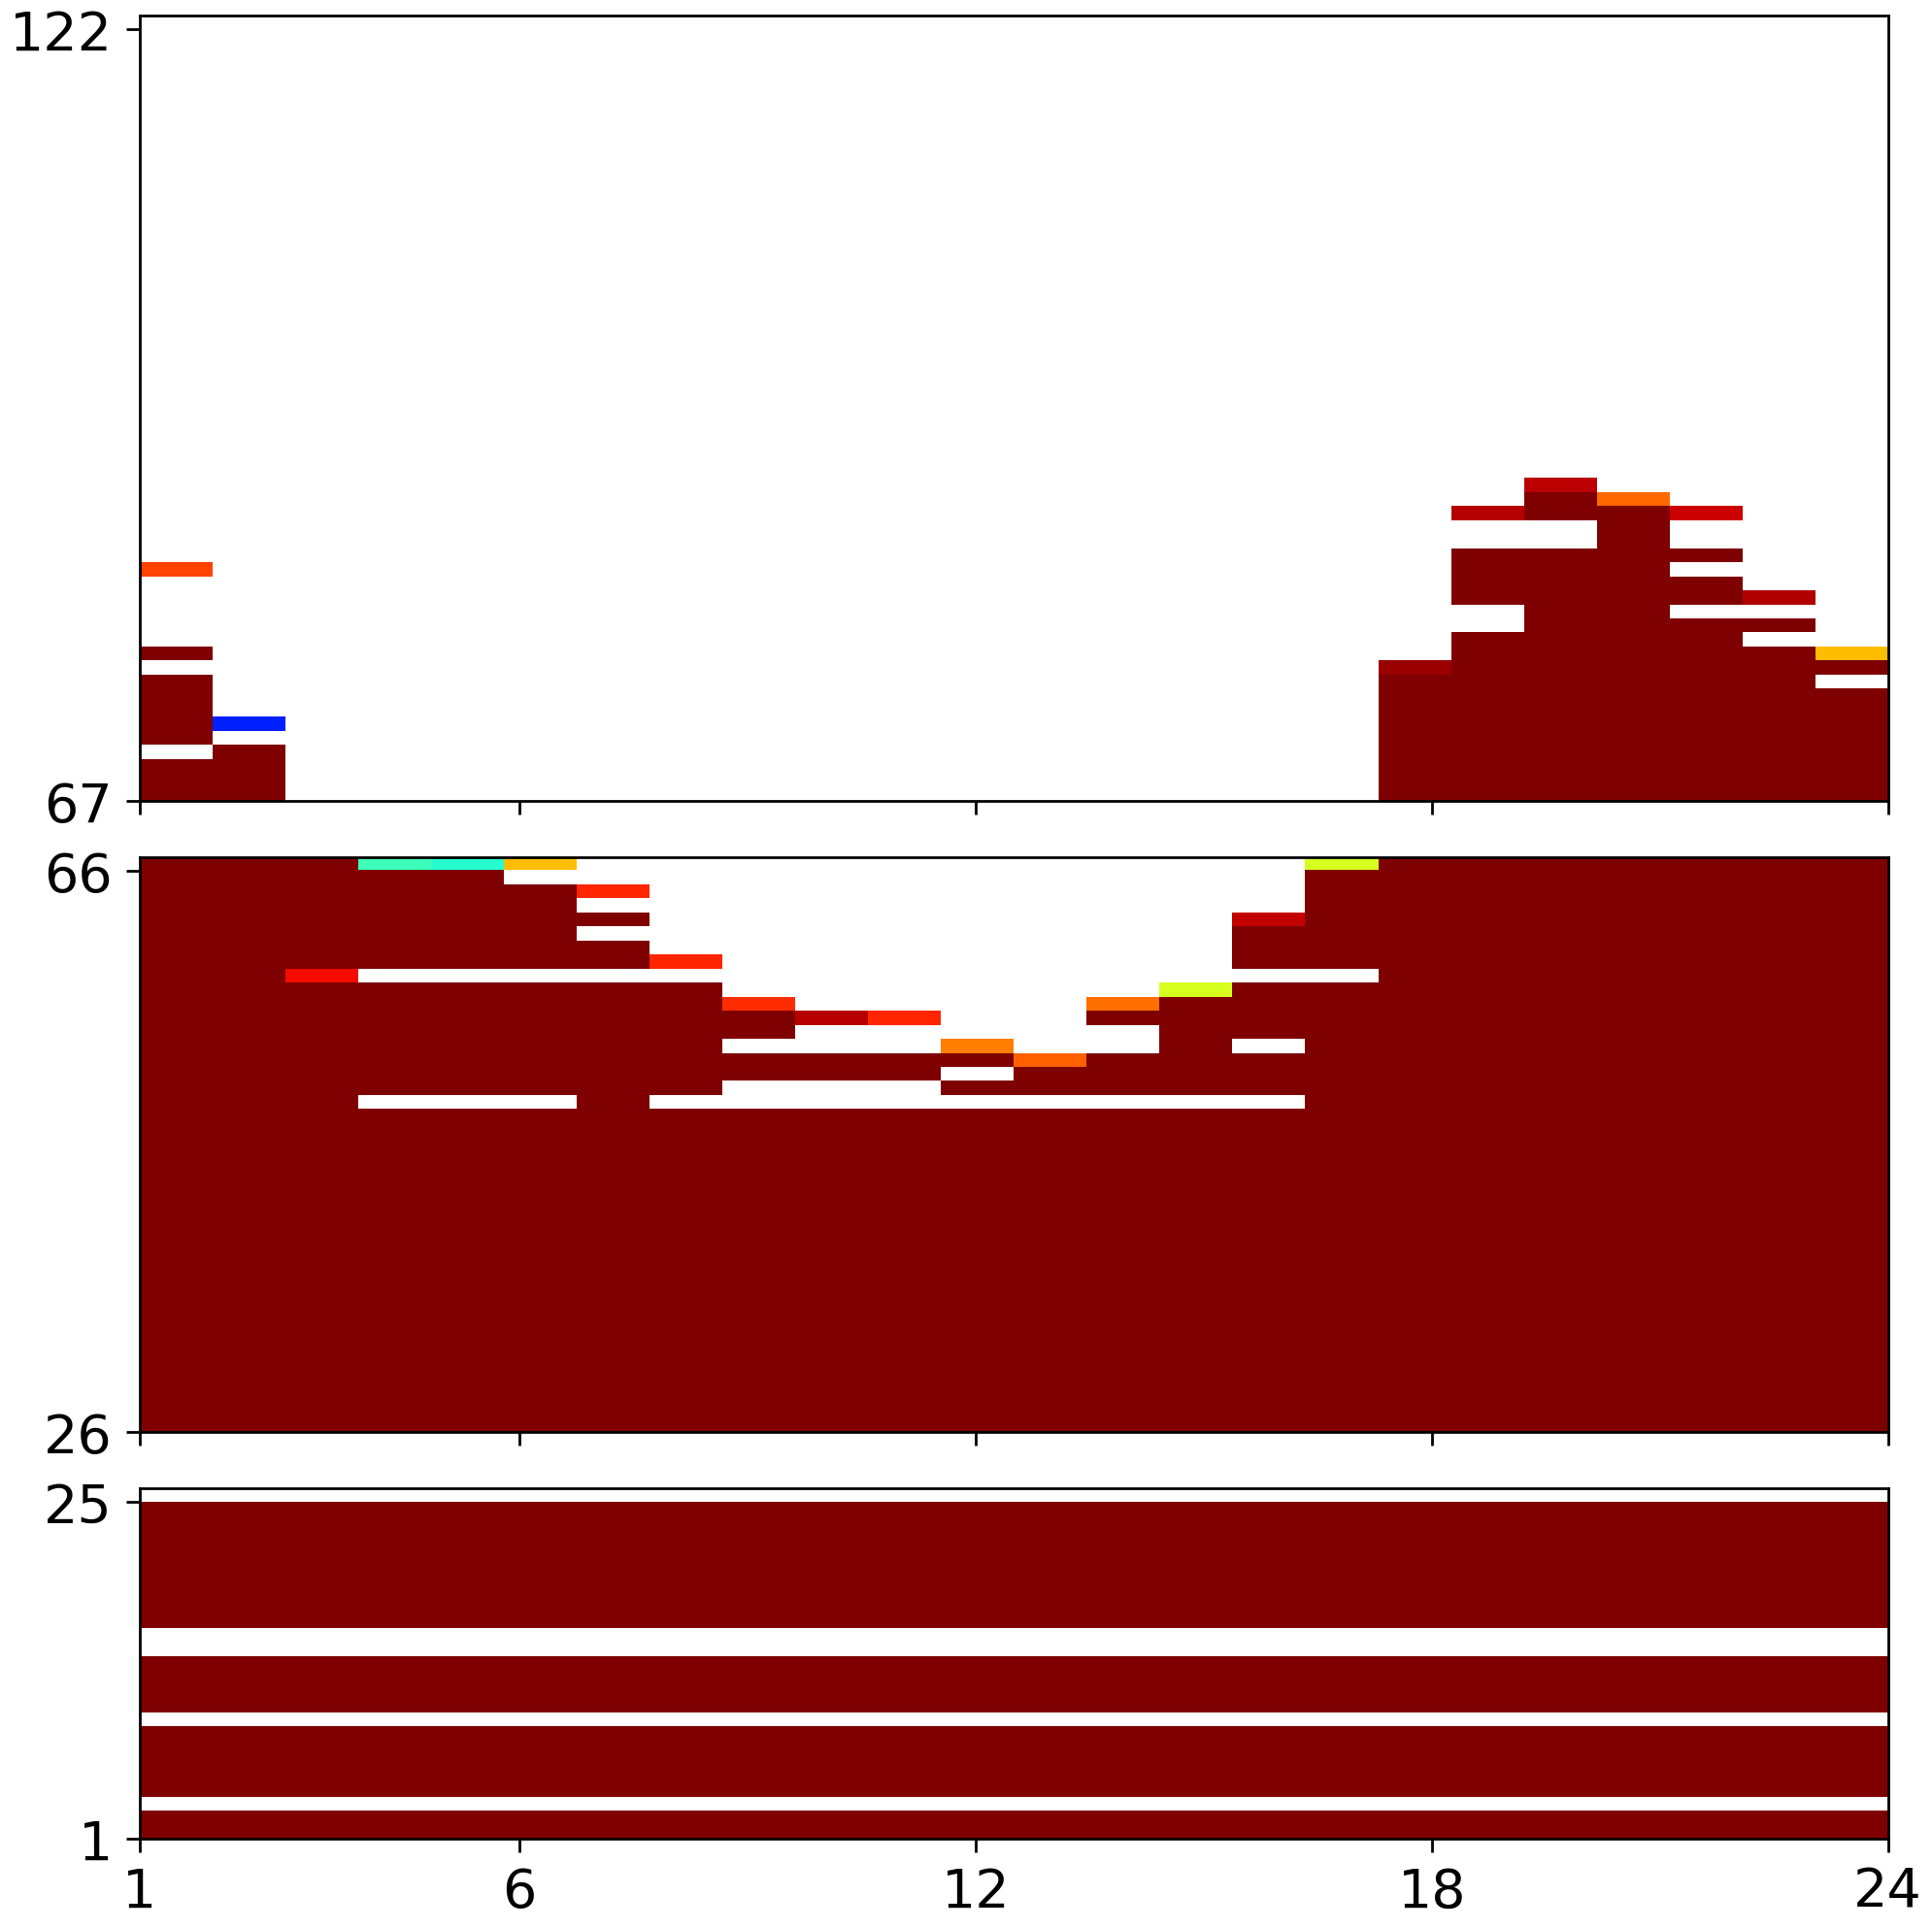

In [13]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

sorted_idx = np.argsort(cost_lin)
sorted_unit_type = unit_type[sorted_idx]

nuclear_idx = sorted_idx[sorted_unit_type == 0]
coal_idx = sorted_idx[sorted_unit_type == 1]
lng_idx = sorted_idx[sorted_unit_type == 2]

# Cumulative start indices
nuclear_start = 0
coal_start = len(nuclear_idx)
lng_start = coal_start + len(coal_idx)

unit_groups = [
    (lng_idx, lng_start),
    (coal_idx, coal_start),
    (nuclear_idx, nuclear_start)
]

fig, axes = plt.subplots(3, 1, figsize=(20, 20), gridspec_kw={'height_ratios': [56/122, 41/122, 25/122]}, sharex=True)

cmap = plt.cm.jet.copy()
cmap.set_bad(color='white')

for ax, (idx_group, start_idx) in zip(axes, unit_groups):
    p_sorted = output_uc_snapshot.p[idx_group, :]
    u_sorted = output_uc_snapshot.u[idx_group, :]
    p_min_sorted = p_min[idx_group]
    p_max_sorted = p_max[idx_group]

    num_units_group = len(idx_group)

    commitment_matrix = np.full_like(p_sorted, np.nan, dtype=float)

    for i in range(num_units_group):
        mask_off = (u_sorted[i, :] == 0)
        mask_at_pmin = (u_sorted[i, :] == 1) & (p_sorted[i, :] == p_min_sorted[i])
        mask_active = (u_sorted[i, :] == 1) & (p_sorted[i, :] > p_min_sorted[i])

        commitment_matrix[i, mask_at_pmin] = 0
        commitment_matrix[i, mask_active] = ((p_sorted[i, mask_active] - p_min_sorted[i]) / 
                                             (p_max_sorted[i] - p_min_sorted[i])) * 100

    ax.imshow(commitment_matrix, aspect='auto', cmap=cmap, origin='lower',
              extent=[1, 24, start_idx, start_idx + num_units_group], vmin=0, vmax=100)

    ax.set_yticks([start_idx, start_idx + num_units_group - 1])
    ax.set_yticklabels([start_idx + 1, start_idx + num_units_group], fontsize=40)

    ax.tick_params(axis="both", width=2, length=10, pad=10, labelsize=40)

    for side in ["bottom", "left", "top", "right"]:
        ax.spines[side].set_linewidth(2)

axes[-1].set_xticks([1, 6, 12, 18, 24])
axes[-1].set_xticklabels([1, 6, 12, 18, 24], fontsize=40)

plt.tight_layout()
plt.show()

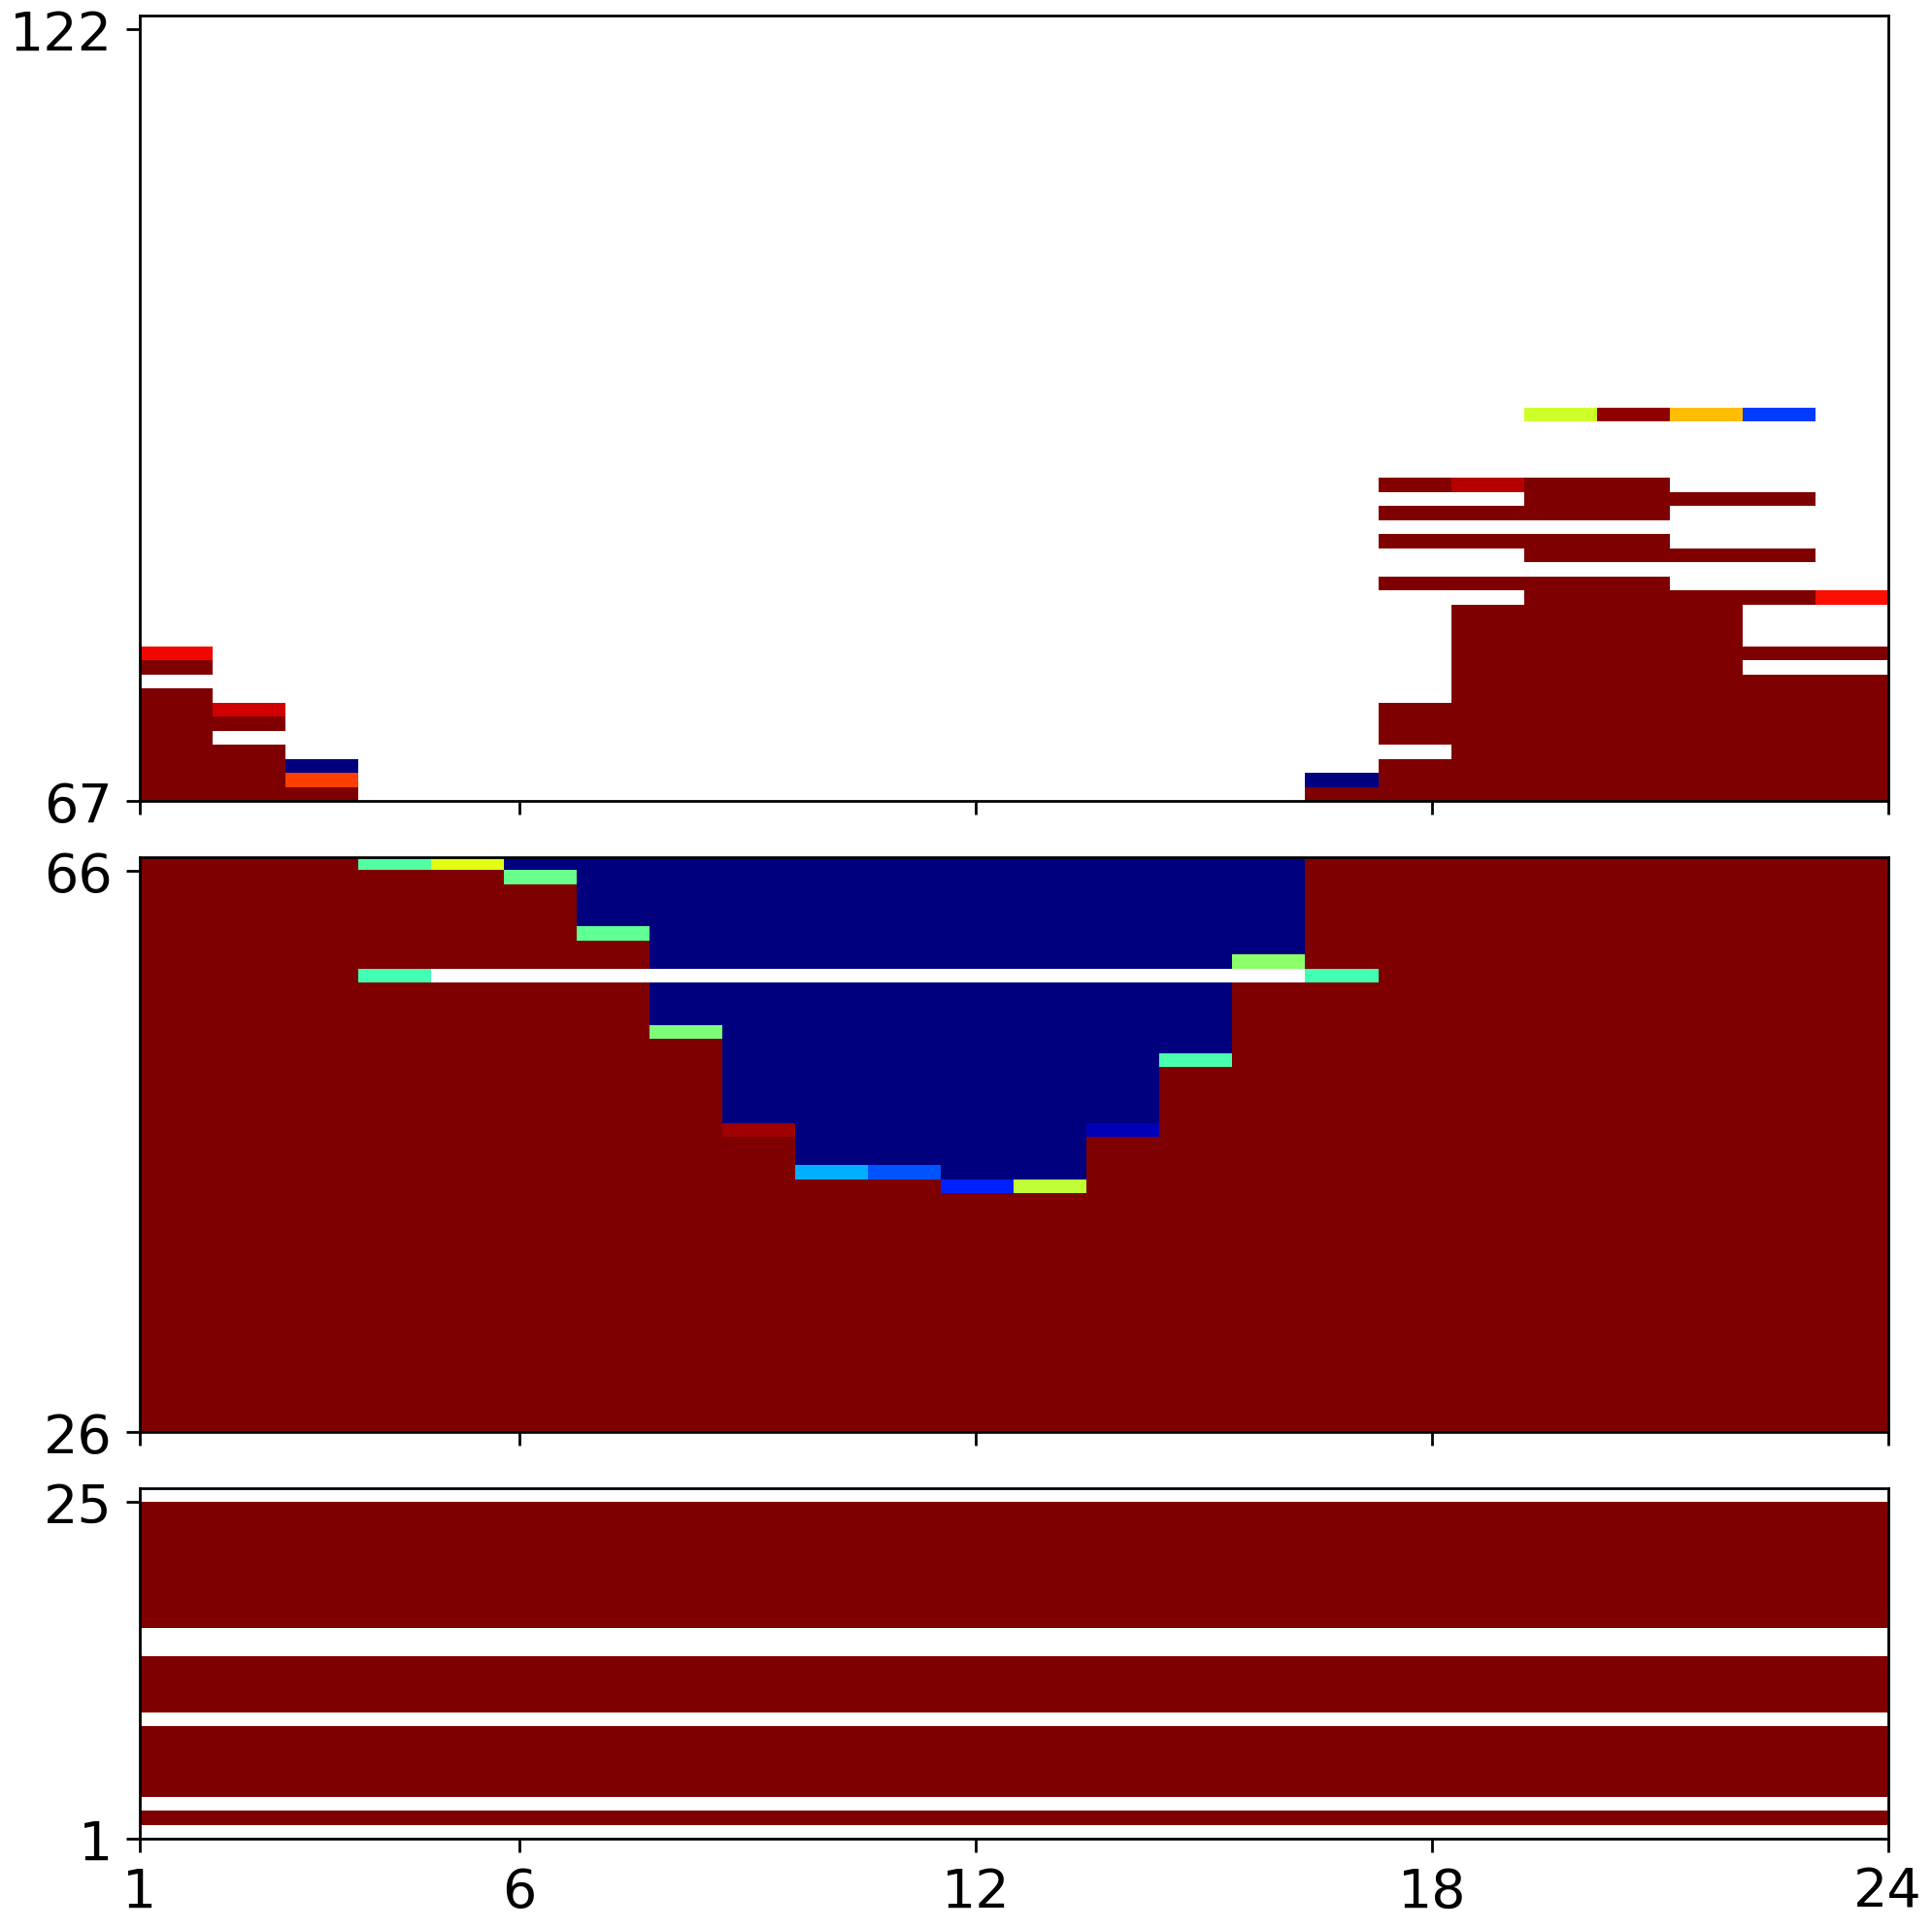

In [14]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

sorted_idx = np.argsort(cost_lin)
sorted_unit_type = unit_type[sorted_idx]

nuclear_idx = sorted_idx[sorted_unit_type == 0]
coal_idx = sorted_idx[sorted_unit_type == 1]
lng_idx = sorted_idx[sorted_unit_type == 2]

# Cumulative start indices
nuclear_start = 0
coal_start = len(nuclear_idx)
lng_start = coal_start + len(coal_idx)

unit_groups = [
    (lng_idx, lng_start),
    (coal_idx, coal_start),
    (nuclear_idx, nuclear_start)
]

fig, axes = plt.subplots(3, 1, figsize=(20, 20), gridspec_kw={'height_ratios': [56/122, 41/122, 25/122]}, sharex=True)

cmap = plt.cm.jet.copy()
cmap.set_bad(color='white')

for ax, (idx_group, start_idx) in zip(axes, unit_groups):
    p_sorted = output_uc.p[idx_group, :]
    u_sorted = output_uc.u[idx_group, :]
    p_min_sorted = p_min[idx_group]
    p_max_sorted = p_max[idx_group]

    num_units_group = len(idx_group)

    commitment_matrix = np.full_like(p_sorted, np.nan, dtype=float)

    for i in range(num_units_group):
        mask_off = (u_sorted[i, :] == 0)
        mask_at_pmin = (u_sorted[i, :] == 1) & (p_sorted[i, :] == p_min_sorted[i])
        mask_active = (u_sorted[i, :] == 1) & (p_sorted[i, :] > p_min_sorted[i])

        commitment_matrix[i, mask_at_pmin] = 0
        commitment_matrix[i, mask_active] = ((p_sorted[i, mask_active] - p_min_sorted[i]) / 
                                             (p_max_sorted[i] - p_min_sorted[i])) * 100

    ax.imshow(commitment_matrix, aspect='auto', cmap=cmap, origin='lower',
              extent=[1, 24, start_idx, start_idx + num_units_group], vmin=0, vmax=100)

    ax.set_yticks([start_idx, start_idx + num_units_group - 1])
    ax.set_yticklabels([start_idx + 1, start_idx + num_units_group], fontsize=40)

    ax.tick_params(axis="both", width=2, length=10, pad=10, labelsize=40)

    for side in ["bottom", "left", "top", "right"]:
        ax.spines[side].set_linewidth(2)

axes[-1].set_xticks([1, 6, 12, 18, 24])
axes[-1].set_xticklabels([1, 6, 12, 18, 24], fontsize=40)

plt.tight_layout()
plt.show()

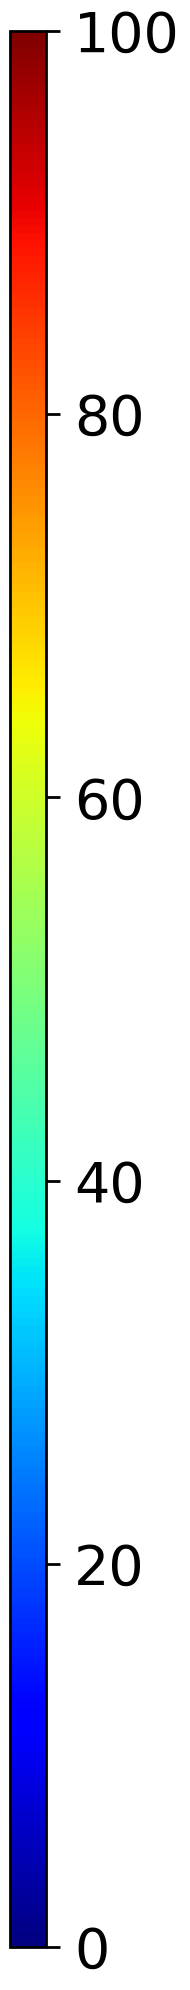

In [15]:
fig, ax = plt.subplots(figsize=(2, 20))

norm = plt.Normalize(vmin=0, vmax=100)
cmap = plt.cm.jet

cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                  cax=ax, orientation='vertical')

cb.ax.tick_params(labelsize=40)


fig_height = 20


# Large tick parameters and borders for consistency
cb.ax.tick_params(
    axis="both", width=(fig_height / 10), length=(fig_height / 2), 
    pad=10, labelsize=(fig_height * 2), which="major",
)
cb.ax.tick_params(
    axis="both", width=0, length=0, labelsize=0, which="minor",
)

# Ensure visible and thick spines (borders)
for side in ["bottom", "left", "top", "right"]:
    cb.outline.set_linewidth(fig_height / 10)

plt.tight_layout()
plt.show()